In [88]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls

from src.network_sim import NetworkSimulator


%reload_ext autoreload
%autoreload 2
%aimport src

In [39]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [51]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-122.007384,-119.571356
1,-122.748650,-109.684520
2,-126.142365,-101.980873
3,-127.494585,-115.427617
4,-128.557405,-103.483333
5,-139.242031,-108.748336
6,-124.907057,-100.610955
7,-117.527728,-110.565438
8,-98.610662,-106.076738
9,-130.821394,-96.567421


In [96]:
simulator = NetworkSimulator(Tx_radius=50, Rx_radius=20, num_Tx_known=3, num_Rx_per_Tx_known=5, num_Tx_unknown=2, num_Rx_per_Tx_unknown=3)

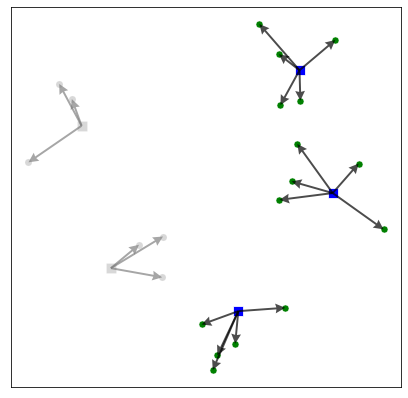

In [97]:
simulator.plot_network()

,0
0,-79.354562
1,-108.806968
2,-103.294653
3,-106.727921
4,-105.970865
...,...
100,-118.190716
101,-112.020765
102,-121.149387
103,-91.823629


In [105]:
pd.DataFrame(simulator.gain_mat)

0       [-79.35456213730215]
1      [-108.80696840802192]
2      [-103.29465252744748]
3      [-106.72792073263662]
4      [-105.97086453573071]
               ...          
100    [-118.19071571739396]
101    [-112.02076475925621]
102     [-121.1493866402593]
103     [-91.82362873475158]
104     [-88.35917941608258]
Length: 105, dtype: object

In [106]:
simulator.gain_mat

array([[ -79.35456214],
       [-108.80696841],
       [-103.29465253],
       [-106.72792073],
       [-105.97086454],
       [ -82.15885078],
       [-101.79375767],
       [-100.59992567],
       [-115.24064572],
       [-105.20416186],
       [-102.74079534],
       [-102.2237957 ],
       [-118.06357497],
       [-105.23520362],
       [-107.12403304],
       [ -86.80046778],
       [-106.00498053],
       [-101.33454387],
       [-106.54857268],
       [-112.71234437],
       [ -83.63703814],
       [-110.0602026 ],
       [-100.28181893],
       [-116.24203195],
       [-109.76349983],
       [-111.45490552],
       [ -98.9811474 ],
       [-106.0692057 ],
       [-104.82101821],
       [-117.30269325],
       [ -99.24638663],
       [ -85.72080975],
       [-105.60546035],
       [-105.67684239],
       [-110.63581812],
       [-109.76429101],
       [ -86.24741296],
       [-101.25189456],
       [ -94.24940371],
       [-106.69455374],
       [-117.42051056],
       [-105.055